# Eval 5: Batch Effect Invariance

**Biological question**: Are the learned representations confounded by technical artifacts?

**Setup**: Train classifiers on frozen cell embeddings to predict batch ID vs perturbation ID.

**Metrics**: Batch prediction accuracy (lower is better), Perturbation prediction accuracy (higher is better)

**Story**: We want representations that capture biology, not technical variation. If batch is easily predictable, the model may be learning shortcuts. If perturbation is predictable but batch isn't, we're capturing the right signal.

## Setup

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split

from eval_common import get_paths, load_biojepa_model, load_perturbation_bank, update_eval_report, DEFAULT_CONFIG
from bio_dataloader import TrainingLoader
from linear_classifier import train_linear_classifier

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

paths = get_paths()
input_bank = load_perturbation_bank(paths, device)
biojepa = load_biojepa_model(paths, device)

Using cpu
Input Bank (DNA): torch.Size([1250, 1536])
<All keys matched successfully>


## Extract Embeddings

Run inference on test set to extract frozen encoder embeddings along with batch and perturbation IDs.

In [3]:
test_loader = TrainingLoader(
    batch_size=DEFAULT_CONFIG['batch_size'],
    split='test',
    data_dir=paths['train_dir'],
    device=device,
    return_batch_id=True
)
test_steps = DEFAULT_CONFIG['test_total_examples'] // DEFAULT_CONFIG['batch_size']

all_embeddings = []
all_batch_ids = []
all_pert_ids = []

with torch.no_grad():
    for step in tqdm(range(test_steps), desc='Extracting embeddings'):
        cont_x, cont_tot, case_x, case_tot, p_idx, p_mod, p_mode, batch_id = test_loader.next_batch()
        
        z_context = biojepa.student(cont_x, cont_tot, mask_idx=None)
        emb = z_context.mean(dim=1).cpu().numpy()
        
        all_embeddings.append(emb)
        all_batch_ids.append(batch_id.cpu().numpy())
        all_pert_ids.append(p_idx.cpu().numpy())

embeddings = np.concatenate(all_embeddings, axis=0)
batch_ids = np.concatenate(all_batch_ids, axis=0).flatten()
pert_ids = np.concatenate(all_pert_ids, axis=0).flatten()

print(f'Embeddings shape: {embeddings.shape}')
print(f'Unique batches: {len(np.unique(batch_ids))}')
print(f'Unique perturbations: {len(np.unique(pert_ids))}')

found 4 shards for split test
loading /Users/djemec/data/jepa/v0_4/training/test/shard_k562e_test_0002.npz


Extracting embeddings:  26%|██████▋                   | 312/1213 [00:34<01:44,  8.65it/s]

loading /Users/djemec/data/jepa/v0_4/training/test/shard_k562e_test_0000.npz


Extracting embeddings:  52%|█████████████▍            | 625/1213 [01:09<01:08,  8.64it/s]

loading /Users/djemec/data/jepa/v0_4/training/test/shard_k562e_test_0003.npz


Extracting embeddings:  74%|███████████████████▎      | 900/1213 [01:40<00:38,  8.04it/s]

loading /Users/djemec/data/jepa/v0_4/training/test/shard_k562e_test_0001.npz


Extracting embeddings: 100%|█████████████████████████| 1213/1213 [02:15<00:00,  8.92it/s]

Embeddings shape: (38816, 8)
Unique batches: 48
Unique perturbations: 286


## Data Statistics

In [4]:
batch_counts = Counter(batch_ids)
pert_counts = Counter(pert_ids)

print(f'Batch distribution: {len(batch_counts)} unique batches')
print(f'  Min samples per batch: {min(batch_counts.values())}')
print(f'  Max samples per batch: {max(batch_counts.values())}')
print(f'  Mean samples per batch: {np.mean(list(batch_counts.values())):.1f}')
print()
print(f'Perturbation distribution: {len(pert_counts)} unique perturbations')
print(f'  Min samples per pert: {min(pert_counts.values())}')
print(f'  Max samples per pert: {max(pert_counts.values())}')
print(f'  Mean samples per pert: {np.mean(list(pert_counts.values())):.1f}')

Batch distribution: 48 unique batches
  Min samples per batch: 402
  Max samples per batch: 1013
  Mean samples per batch: 808.7

Perturbation distribution: 286 unique perturbations
  Min samples per pert: 1
  Max samples per pert: 688
  Mean samples per pert: 135.7


## Train Linear Classifiers

Train simple linear classifiers on frozen embeddings to predict:
1. **Batch ID** - Low accuracy desired (batch info not encoded)
2. **Perturbation ID** - High accuracy desired (biological signal encoded)

In [5]:
batch_label_map = {b: i for i, b in enumerate(sorted(np.unique(batch_ids)))}
pert_label_map = {p: i for i, p in enumerate(sorted(np.unique(pert_ids)))}

batch_labels = np.array([batch_label_map[b] for b in batch_ids])
pert_labels = np.array([pert_label_map[p] for p in pert_ids])

num_batch_classes = len(batch_label_map)
num_pert_classes = len(pert_label_map)

print(f'Batch classes: {num_batch_classes}')
print(f'Perturbation classes: {num_pert_classes}')

Batch classes: 48
Perturbation classes: 286


In [6]:
indices = np.arange(len(embeddings))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

X_train, X_val = embeddings[train_idx], embeddings[val_idx]
batch_train, batch_val = batch_labels[train_idx], batch_labels[val_idx]
pert_train, pert_val = pert_labels[train_idx], pert_labels[val_idx]

print(f'Train samples: {len(X_train)}')
print(f'Val samples: {len(X_val)}')

Train samples: 31052
Val samples: 7764


### Train Batch Classifier

In [7]:
print('Training batch classifier...')
batch_classifier, batch_preds, batch_acc = train_linear_classifier(
    X_train, batch_train, X_val, batch_val, num_batch_classes, device, epochs=100
)

batch_chance = 1.0 / num_batch_classes
print(f'\nBatch Classification Accuracy: {batch_acc:.4f}')
print(f'Chance level: {batch_chance:.4f}')
print(f'Above chance: {batch_acc - batch_chance:.4f}')

Training batch classifier...

Batch Classification Accuracy: 0.0287
Chance level: 0.0208
Above chance: 0.0079


### Train Perturbation Classifier

In [8]:
print('Training perturbation classifier...')
pert_classifier, pert_preds, pert_acc = train_linear_classifier(
    X_train, pert_train, X_val, pert_val, num_pert_classes, device, epochs=100
)

pert_chance = 1.0 / num_pert_classes
print(f'\nPerturbation Classification Accuracy: {pert_acc:.4f}')
print(f'Chance level: {pert_chance:.4f}')
print(f'Above chance: {pert_acc - pert_chance:.4f}')

Training perturbation classifier...

Perturbation Classification Accuracy: 0.0079
Chance level: 0.0035
Above chance: 0.0044


## Analysis

In [9]:
batch_above_chance = batch_acc / batch_chance
pert_above_chance = pert_acc / pert_chance

print('INVARIANCE RATIO')
print(f'  Perturbation/Batch accuracy ratio: {pert_acc/batch_acc:.2f}x')
print(f'  Perturbation above chance: {pert_above_chance:.1f}x')
print(f'  Batch above chance: {batch_above_chance:.1f}x')
print()
if batch_acc < 2 * batch_chance and pert_acc > 5 * pert_chance:
    print('GOOD: Embeddings encode perturbation signal but not batch artifacts')
elif batch_acc > 5 * batch_chance:
    print('WARNING: Batch information is strongly encoded in embeddings')
else:
    print('MIXED: Some batch information may be encoded')

INVARIANCE RATIO
  Perturbation/Batch accuracy ratio: 0.27x
  Perturbation above chance: 2.2x
  Batch above chance: 1.4x

MIXED: Some batch information may be encoded


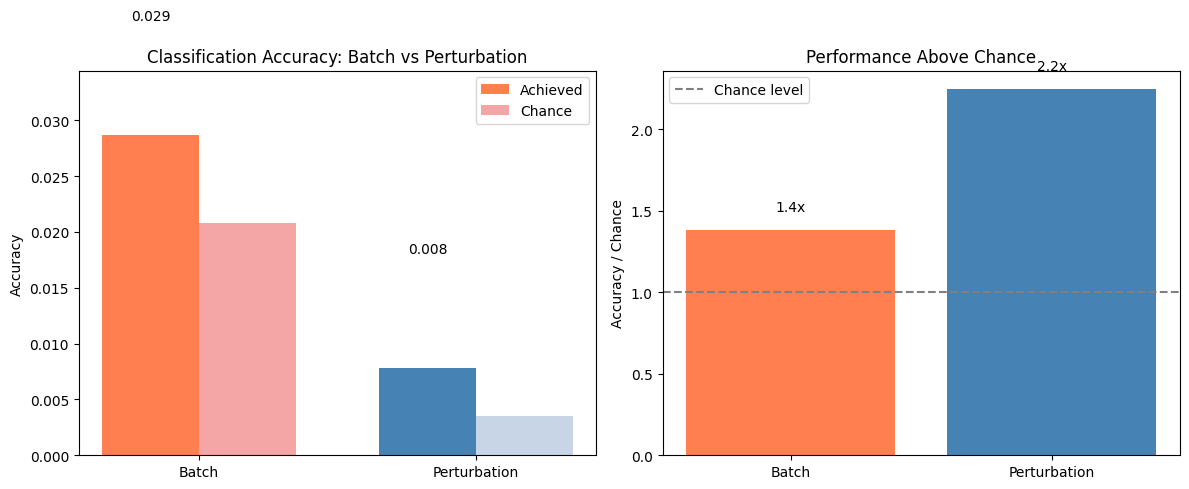

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

labels = ['Batch', 'Perturbation']
accuracies = [batch_acc, pert_acc]
chance_levels = [batch_chance, pert_chance]

x = np.arange(len(labels))
width = 0.35

axes[0].bar(x - width/2, accuracies, width, label='Achieved', color=['coral', 'steelblue'])
axes[0].bar(x + width/2, chance_levels, width, label='Chance', color=['lightcoral', 'lightsteelblue'], alpha=0.7)
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Classification Accuracy: Batch vs Perturbation')
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels)
axes[0].legend()
axes[0].set_ylim(0, max(accuracies) * 1.2)

for i, (acc, chance) in enumerate(zip(accuracies, chance_levels)):
    axes[0].text(i - width/2, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom', fontsize=10)

above_chance = [batch_above_chance, pert_above_chance]
colors = ['coral', 'steelblue']
axes[1].bar(labels, above_chance, color=colors)
axes[1].axhline(y=1, color='gray', linestyle='--', label='Chance level')
axes[1].set_ylabel('Accuracy / Chance')
axes[1].set_title('Performance Above Chance')
axes[1].legend()

for i, val in enumerate(above_chance):
    axes[1].text(i, val + 0.1, f'{val:.1f}x', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Benchmark Results

In [11]:
print('='*70)
print('EVAL 5: BATCH EFFECT INVARIANCE - BENCHMARK RESULTS')
print('='*70)
print()
print('CONFIGURATION')
print(f'  Samples: {len(embeddings):,}')
print(f'  Embedding dim: {embeddings.shape[1]}')
print(f'  Unique batches: {num_batch_classes}')
print(f'  Unique perturbations: {num_pert_classes}')
print()
print('BATCH CLASSIFIER (lower is better)')
print(f'  Accuracy: {batch_acc:.4f}')
print(f'  Chance:   {batch_chance:.4f}')
print(f'  Ratio:    {batch_above_chance:.2f}x chance')
print()
print('PERTURBATION CLASSIFIER (higher is better)')
print(f'  Accuracy: {pert_acc:.4f}')
print(f'  Chance:   {pert_chance:.4f}')
print(f'  Ratio:    {pert_above_chance:.2f}x chance')
print()
print('INVARIANCE METRICS')
print(f'  Pert/Batch accuracy ratio: {pert_acc/batch_acc:.2f}x')

EVAL 5: BATCH EFFECT INVARIANCE - BENCHMARK RESULTS

CONFIGURATION
  Samples: 38,816
  Embedding dim: 8
  Unique batches: 48
  Unique perturbations: 286

BATCH CLASSIFIER (lower is better)
  Accuracy: 0.0287
  Chance:   0.0208
  Ratio:    1.38x chance

PERTURBATION CLASSIFIER (higher is better)
  Accuracy: 0.0079
  Chance:   0.0035
  Ratio:    2.25x chance

INVARIANCE METRICS
  Pert/Batch accuracy ratio: 0.27x


In [12]:
update_eval_report('eval_5_batch_invariance', {
    'config': {
        'samples': len(embeddings),
        'embedding_dim': int(embeddings.shape[1]),
        'num_batches': num_batch_classes,
        'num_perturbations': num_pert_classes
    },
    'batch_classifier': {
        'accuracy': float(batch_acc),
        'chance': float(batch_chance),
        'above_chance_ratio': float(batch_above_chance)
    },
    'perturbation_classifier': {
        'accuracy': float(pert_acc),
        'chance': float(pert_chance),
        'above_chance_ratio': float(pert_above_chance)
    },
    'invariance_ratio': float(pert_acc / batch_acc)
})

Updated eval_report.json
